# Обучение моделей в Pytorch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/brisc2025.zip -d my_data

In [5]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.0 MB/s eta 0:00:00


In [25]:
import os
import random
from os.path import join as pjoin
from shutil import rmtree
import cv2

import albumentations
import numpy as np
import torch
from PIL import Image
from accelerate import Accelerator
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets

from checkpointer import CheckpointSaver, load_checkpoint
from dataset import CLASS_WEIGHTS, CustomVOCSegmentation, convert_label_to_color
from deeplabv3plus.modeling import deeplabv3plus_resnet50
from loss import CrossEntropyDiceLoss
from metric import MeanIoU
from train import count_pytorch_model_params, train
from unet import UNet
from unet_custom import CustomUNet
from utils import seed_everything

In [7]:
seed_everything(42, torch_deterministic=False)

In [20]:
class CustomSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # --- FIX for 0/255 masks ---
        mask = (mask > 127).long()       # теперь 0 и 1, тип long
        # -----------------------------

        return image, mask


## Аугментации

Трансформации/аугментации для исходных изображений и масок/таргетов.

Аугментации для задач компьютерного хрения: https://albumentations.ai/

In [9]:
IMAGE_SIZE = 256
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

train_transforms = albumentations.Compose(
    [
        albumentations.SmallestMaxSize(max_size=IMAGE_SIZE),
        albumentations.CropNonEmptyMaskIfExists(height=IMAGE_SIZE, width=IMAGE_SIZE),
        # albumentations.Resize(IMAGE_SIZE, IMAGE_SIZE),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.ShiftScaleRotate(
            shift_limit=0.05,
            scale_limit=0.1,
            rotate_limit=15,
            p=0.5,
        ),
        albumentations.RandomCrop(IMAGE_SIZE, IMAGE_SIZE, p=1.0),
        albumentations.OneOf(
            [
                albumentations.CLAHE(p=0.3),
                albumentations.RandomBrightnessContrast(p=0.5),
                albumentations.HueSaturationValue(p=0.3),
            ],
            p=0.8,
        ),
        albumentations.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ]
)

val_transforms = albumentations.Compose(
    [
        albumentations.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),
        albumentations.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ]
)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## Dataset

Набор данных Pascal VOC. Рассмотрим его версию для задачи сегментации.

Сайт: http://host.robots.ox.ac.uk/pascal/VOC/

Лидерборд за 2012 год: http://host.robots.ox.ac.uk:8080/leaderboard/displaylb_main.php?challengeid=11&compid=5

При тех или иных проблемах со скачиванием с сайта соревнования, скачайте и распакуйте архив в папку `data` (`data/VOCdevkit`) отсюда: https://disk.yandex.ru/d/1jS3yBBN7YdZ-w

In [26]:
train_dataset = CustomSegmentationDataset(
    img_dir="my_data/brisc2025/segmentation_task/train/images",
    mask_dir="my_data/brisc2025/segmentation_task/train/masks",
    transform=train_transforms
)

val_dataset = CustomSegmentationDataset(
    img_dir="my_data/brisc2025/segmentation_task/test/images",
    mask_dir="my_data/brisc2025/segmentation_task/test/masks",
    transform=val_transforms
)


/tmp/ipython-input-2769035497.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image_orig = image * STD[:, None, None] + MEAN[:, None, None]


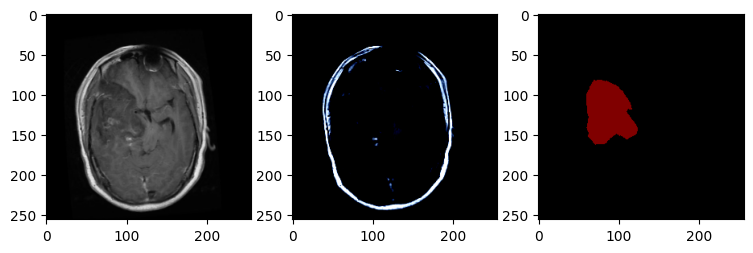

In [27]:
image, target = train_dataset[0]

image_orig = image * STD[:, None, None] + MEAN[:, None, None]

fig, ax = plt.subplots(1, 3, figsize=(9, 18))
ax[0].imshow(image_orig.numpy().transpose(1, 2, 0) + 1e-5)
ax[1].imshow(image.numpy().transpose(1, 2, 0))
ax[2].imshow(convert_label_to_color(target.numpy()))

## UNet model

Статья: https://arxiv.org/abs/1505.04597

In [28]:
model = UNet(in_channels=3, out_channels=21)
print(model)

UNet(
  (in_conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): _Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3)

In [29]:
count_pytorch_model_params(model)

17264277

## Accelerator

"Accelerate — это библиотека, которая позволяет запускать один и тот же код PyTorch в любой распределенной конфигурации, добавляя всего четыре строки кода! Короче говоря, обучение и вывод в больших масштабах стали простыми, эффективными и адаптируемыми". (c)

Сайт: https://huggingface.co/docs/accelerate/index

In [30]:
accelerator = Accelerator(cpu=False, mixed_precision="no")

## Checkpointer

Класс для сохранения наилучших версий модели в процессе обучения.

См. класс `Checkpointer` в `train.py`

## Обучаем модель

См. `train.py`

In [36]:
CLASSES_NUM = 21

BACKBONE_NAME = "resnet50"

LEARNING_RATE_SGD = 1e-3
LEARNING_RATE_ADAM = 1e-4
MIN_LEARNING_RATE = 1e-6
WEIGHT_DECAY = 1e-4
MOMENTUM_SGD = 0.9
BETAS_ADAM = (0.9, 0.999)
BATCH_SIZE = 16
NUM_WORKERS = 4
EPOCH_NUM = 5
SCHEDULER_PATIENCE = 5
SCHEDULER_GAMMA = 0.5
CHECKPOINTS_DIR = "checkpoints"
TENSORBOARD_DIR = "tensorboard"
RM_CHECKPOINTS_DIR = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    drop_last=False,
)

accelerator = Accelerator(cpu=DEVICE=="cpu", mixed_precision="no")

# model = UNet(in_channels=3, out_channels=CLASSES_NUM, bilinear=True)
model = CustomUNet(backbone_name=BACKBONE_NAME, classes_num=CLASSES_NUM)
# model = deeplabv3plus_resnet50()

# model = load_checkpoint(
#     model=model,
#     load_path=pjoin(CHECKPOINTS_DIR, "model_checkpoint_best.pt"),
# )

class_weights = torch.tensor(CLASS_WEIGHTS).to(DEVICE)
# loss_fn = nn.CrossEntropyLoss(weight=class_weights, reduction="mean", ignore_index=255)
loss_fn = CrossEntropyDiceLoss(weight=class_weights, ignore_index=255)

metric_fn = MeanIoU(classes_num=CLASSES_NUM, ignore_index=255).to(DEVICE)
metric_fns = {metric_fn.__class__.__name__: metric_fn}

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE_SGD,
    weight_decay=WEIGHT_DECAY,
    nesterov=True,
    momentum=MOMENTUM_SGD,
)
# optimizer = torch.optim.AdamW(
#     model.parameters(), lr=LEARNING_RATE_ADAM, weight_decay=WEIGHT_DECAY, betas=BETAS_ADAM
# )

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode="max",
    factor=SCHEDULER_GAMMA,
    patience=SCHEDULER_PATIENCE,
    min_lr=MIN_LEARNING_RATE,
)

os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
checkpointer = CheckpointSaver(
    accelerator=accelerator,
    model=model,
    metric_name=metric_fn.__class__.__name__,
    save_dir=CHECKPOINTS_DIR,
    rm_save_dir=RM_CHECKPOINTS_DIR,
    max_history=5,
    should_minimize=False,
)

In [38]:
os.makedirs(TENSORBOARD_DIR, exist_ok=True)
tensorboard_logger = torch.utils.tensorboard.SummaryWriter(log_dir=TENSORBOARD_DIR)

###################################################
# Раскомментировать в Google Colab
# %load_ext tensorboard
# %tensorboard --logdir "tensorboard"  --port 6006
###################################################

In [39]:
model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)

In [40]:
train(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    metric_fns=metric_fns,
    lr_scheduler=lr_scheduler,
    accelerator=accelerator,
    epoch_num=EPOCH_NUM,
    checkpointer=checkpointer,
    tb_logger=tensorboard_logger,
    save_on_val=True,
)

INFO:train:Trainable parameters in the model: 45938269


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:train:Epoch 1/5


Training:   0%|          | 0/245 [00:00<?, ?it/s]

INFO:train:Train CrossEntropyDiceLoss: 0.87553
INFO:train:Train MeanIoU: 0.04662


Validation:   0%|          | 0/54 [00:00<?, ?it/s]

INFO:train:Val CrossEntropyDiceLoss: 0.34108
INFO:train:Val MeanIoU: 0.06033
INFO:checkpointer:Best epoch MeanIoU value is 0.0603 on 1 epoch
INFO:train:Epoch 2/5


Training:   0%|          | 0/245 [00:00<?, ?it/s]

INFO:train:Train CrossEntropyDiceLoss: 0.30202
INFO:train:Train MeanIoU: 0.06464


Validation:   0%|          | 0/54 [00:00<?, ?it/s]

INFO:train:Val CrossEntropyDiceLoss: 0.27327
INFO:train:Val MeanIoU: 0.06843
INFO:checkpointer:Best epoch MeanIoU value is 0.0684 on 2 epoch
INFO:train:Epoch 3/5


Training:   0%|          | 0/245 [00:00<?, ?it/s]

INFO:train:Train CrossEntropyDiceLoss: 0.26415
INFO:train:Train MeanIoU: 0.06733


Validation:   0%|          | 0/54 [00:00<?, ?it/s]

INFO:train:Val CrossEntropyDiceLoss: 0.26316
INFO:train:Val MeanIoU: 0.06638
INFO:checkpointer:Best epoch MeanIoU value is 0.0684 on 2 epoch
INFO:train:Epoch 4/5


Training:   0%|          | 0/245 [00:00<?, ?it/s]

INFO:train:Train CrossEntropyDiceLoss: 0.25194
INFO:train:Train MeanIoU: 0.06865


Validation:   0%|          | 0/54 [00:00<?, ?it/s]

INFO:train:Val CrossEntropyDiceLoss: 0.24976
INFO:train:Val MeanIoU: 0.06578
INFO:checkpointer:Best epoch MeanIoU value is 0.0684 on 2 epoch
INFO:train:Epoch 5/5


Training:   0%|          | 0/245 [00:00<?, ?it/s]

INFO:train:Train CrossEntropyDiceLoss: 0.24246
INFO:train:Train MeanIoU: 0.06976


Validation:   0%|          | 0/54 [00:00<?, ?it/s]

INFO:train:Val CrossEntropyDiceLoss: 0.24407
INFO:train:Val MeanIoU: 0.07522
INFO:checkpointer:Best epoch MeanIoU value is 0.0752 on 5 epoch


## Загрузим и протестируем обученную модель

In [41]:
CHECKPOINTS_DIR = "checkpoints"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# model = UNet(in_channels=3, out_channels=CLASSES_NUM)
model = CustomUNet(backbone_name=BACKBONE_NAME, classes_num=CLASSES_NUM)
# model = deeplabv3plus_resnet50()

model = load_checkpoint(
    model=model,
    load_path=pjoin(CHECKPOINTS_DIR, "model_checkpoint_best.pt"),
)
model = model.to(DEVICE)
model.eval()

CustomUNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

/tmp/ipython-input-2066036096.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image = image * STD[:, None, None] + MEAN[:, None, None]


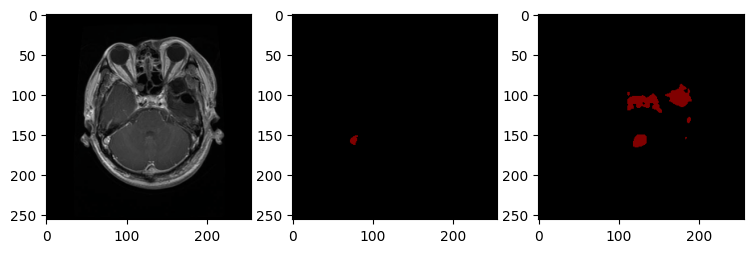

In [42]:
sample_idx = 10
image, target = val_dataset[sample_idx]

preds = torch.argmax(model(image.unsqueeze(0).to(DEVICE)).squeeze(0), axis=0)

image = image * STD[:, None, None] + MEAN[:, None, None]

fig, ax = plt.subplots(1, 3, figsize=(9, 18))
ax[0].imshow(image.numpy().transpose(1, 2, 0))
ax[1].imshow(convert_label_to_color(target.numpy()))
ax[2].imshow(convert_label_to_color(preds.cpu().numpy()));

## Разметка данных с помощью CVAT

Сайт: https://www.cvat.ai/

## Обзоры бекбонов

- Обзор до ~2020: https://arxiv.org/pdf/2206.08016.pdf
- Чуть поновее: https://arxiv.org/pdf/2310.19909.pdf
- Трансформеры и VLM позже